# Здесь описать цели работы, гипотезу и идеи

In [168]:
import requests
import json
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt

# data have many ';' and ','
csv_delimiter = '::'
# indicators to analysis
indicators = [
    'SP.DYN.CDRT.IN',   # Death rate
    'NY.GDP.MKTP.CD',   # GDP (current $)
    'NY.GDP.PCAP.KD',   # GDP per capita (constant 2015 $)
]

def download_json(url: str, filepath: str):
    """Download json from url and return result"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # write bytes to file
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # read downloaded json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Get full list of indicators from specified datasets and write to inticators.csv"""
    datasets_ids = [
        "0037712",  # World Development Indicators
        "0037798",  # Global Economical Monitor
    ]
    with open('indicators.csv', 'wt') as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        for dataset_unique_id in datasets_ids:
            # get dataset info
            dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_unique_id}"
            dataset_metadata_path = f"datasets_metadata/{dataset_unique_id}.json"
            indicators = download_json(dataset_url, dataset_metadata_path)
            # get data for each indicator
            for indicator in indicators["Indicator"]:
                # parse url to get values
                name = indicator.split("::")[0]
                id = indicator.split("=")[-1]
                load = 0
                print(name, id, load, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators=None):
    """Download indicators from DataBank. If not specified based on settings from indicators.csv)"""
    all_indicators = pd.read_csv("indicators.csv", delimiter=csv_delimiter, engine='python')
    if indicators:
        needed_indicators = indicators
    else:
        needed_indicators = all_indicators[all_indicators["load"] == 1]['id']
    df = pd.DataFrame(columns=['country', 'date'])
    for id in needed_indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # skip already loaded indicators
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # check if got valid data
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # convert raw json data to csv
            with open(csv_path, 'wt') as csv_file:
                name = data[1][0]["indicator"]["value"]
                print('country', 'date', name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)
        
        # read downloaded csv
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine='python')
        # drop empty rows
        new.dropna(how='any', inplace=True)
        # merge with main dataset
        df = pd.merge(left=df, right=new, how='outer', on=('country', 'date'))

    return df

In [169]:
# download_indicators_list()
raw_df = get_indicators_data(indicators)

SP.DYN.CDRT.IN is already loaded
NY.GDP.MKTP.CD is already loaded
NY.GDP.PCAP.KD is already loaded


In [170]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16705 entries, 0 to 16704
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   country                               16705 non-null  object 
 1   date                                  16705 non-null  int64  
 2   Death rate, crude (per 1,000 people)  16282 non-null  float64
 3   GDP (current US$)                     13979 non-null  float64
 4   GDP per capita (constant 2015 US$)    13963 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 652.7+ KB


In [171]:
# regions to take into statistics
include_regions = np.array([
       'Afghanistan', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji',
       'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland',
       'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq',
       'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati',
       "Korea, Dem. People's Rep.", 'Korea, Rep.', 'Kosovo', 'Kuwait',
       'Kyrgyz Republic', 'Lao PDR', 'Latvia', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macao SAR, China', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives',
       'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius',
       'Mexico', 'Micronesia, Fed. Sts.', 'Moldova', 'Monaco', 'Mongolia',
       'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia',
       'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia',
       'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau',
       'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Romania',
       'Russian Federation', 'Rwanda', 'Samoa', 'San Marino',
       'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Seychelles', 'Sierra Leone', 'Singapore',
       'Sint Maarten (Dutch part)', 'Slovak Republic', 'Slovenia',
       'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan',
       'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Martin (French part)', 'St. Vincent and the Grenadines',
       'Sudan', 'Suriname', 'Sweden', 'Switzerland',
       'Syrian Arab Republic', 'Tajikistan', 'Tanzania', 'Thailand',
       'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia',
       'Turkiye', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu',
       'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, RB', 'Viet Nam', 'Virgin Islands (U.S.)',
       'West Bank and Gaza', 'Yemen, Rep.', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [180]:
# dataset of needed countries
cleared_df = raw_df[raw_df["country"].isin(include_regions)]

N = 7

top_absolute_GDP_countries = cleared_df[cleared_df["date"] == 2023].sort_values(
    "GDP (current US$)", ascending=False
)[:N]["country"].reset_index(drop=True)
top_GDP_per_capita_countries = cleared_df[cleared_df["date"] == 2023].sort_values(
    "GDP per capita (constant 2015 US$)", ascending=False
)[:N]["country"].reset_index(drop=True)

In [181]:
print(
    f"Top {N} countries by GDP:",
    top_absolute_GDP_countries,
    f"Top {N} countries by GDP per capite:",
    top_GDP_per_capita_countries,
    sep="\n",
)

Top 7 countries by GDP:
0     United States
1             China
2           Germany
3             Japan
4             India
5    United Kingdom
6            France
Name: country, dtype: object
Top 7 countries by GDP per capite:
0       Luxembourg
1          Ireland
2      Switzerland
3           Norway
4        Singapore
5    United States
6        Australia
Name: country, dtype: object


In [182]:
group_1_df = cleared_df[cleared_df['country'].isin(top_absolute_GDP_countries)][cleared_df['date'] >= 1990].sort_values('date', ascending=True)
group_2_df = cleared_df[cleared_df['country'].isin(top_GDP_per_capita_countries)][cleared_df['date'] >= 1990].sort_values('date', ascending=True)

C:\Users\redun\AppData\Local\Temp\ipykernel_47076\2634930646.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_1_df = cleared_df[cleared_df['country'].isin(top_absolute_GDP_countries)][cleared_df['date'] >= 1990].sort_values('date', ascending=True)
C:\Users\redun\AppData\Local\Temp\ipykernel_47076\2634930646.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_2_df = cleared_df[cleared_df['country'].isin(top_GDP_per_capita_countries)][cleared_df['date'] >= 1990].sort_values('date', ascending=True)


In [224]:
from matplotlib import colormaps

def color_gen_f():
    val = 0
    colors_n = 8
    step = 1
    cmap = colormaps.get_cmap('Dark2')
    while True:
        yield cmap(val / colors_n)
        val = (val + step) % colors_n

color_gen = color_gen_f()

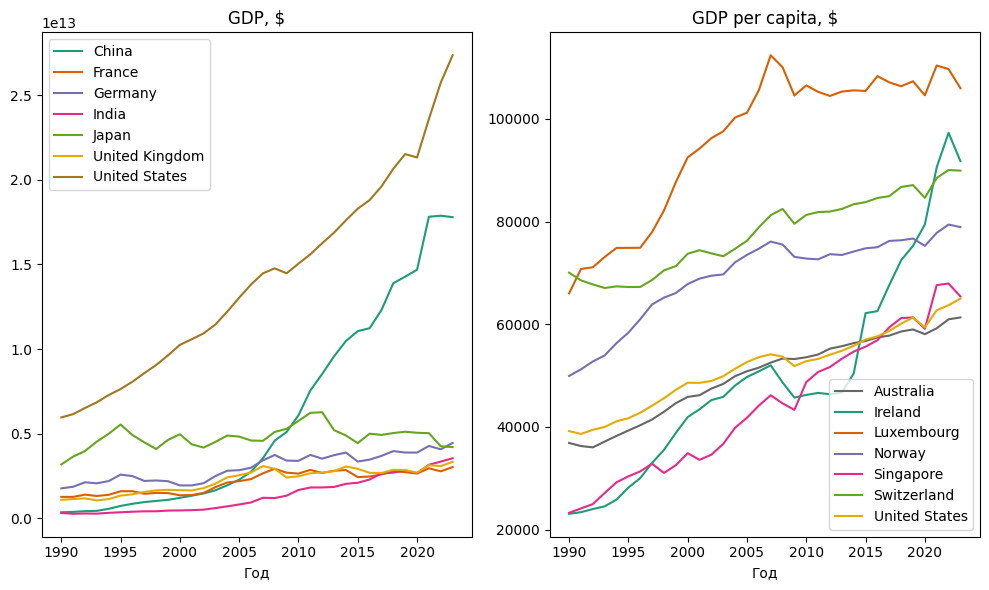

In [225]:
plt.figure("1", figsize=(10, 6))

axes = plt.subplot(1, 2, 1)
plt.title("GDP, $")

for country, series in group_1_df.groupby(['country']):
    axes = series.plot(x='date', y='GDP (current US$)', label=country[0], xlabel='Год', ax=axes, color=next(color_gen))

axes = plt.subplot(1, 2, 2)
plt.title("GDP per capita, $")

for country, series in group_2_df.groupby(['country']):
    axes = series.plot(x='date', y="GDP per capita (constant 2015 US$)", label=country[0], xlabel='Год', ax=axes, color=next(color_gen))

plt.tight_layout()
plt.show()